In [52]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader 

import tiktoken

### Evaluating generative text models

In [3]:
class LayerNorm(nn.Module): 
    def __init__(self, emb_dim): 
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    
    def forward(self, x): 
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift
    
class GELU(nn.Module): 
    def __init__(self): 
        super().__init__() 
        
    def forward(self, x): 
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module): 
    def __init__(self, cfg): 
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), 
            GELU(), 
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
        )
    
    def forward(self, x): 
        return self.layers(x)
    
class MultiHeadAttention(nn.Module): 
    def __init__(self, d_in, d_out, block_size, 
                 dropout, num_heads, qkv_bias=False): 
        super().__init__()
        assert d_out % num_heads == 0, "output dimension must be divisible by the number of heads"
        self.d_out = d_out 
        self.num_heads = num_heads 
        self.head_dim = d_out // num_heads 
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            'mask', 
            torch.triu(torch.ones(block_size, block_size), diagonal=1)
        )
    
    def forward(self, x): 
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x) 
        queries = self.W_query(x)
        values = self.W_value(x) 
        
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim) 
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        queries = queries.transpose(1, 2)
        
        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights)
        
        context_vec = (attn_weights @ values).transpose(1, 2) 
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        return context_vec
    
class TransformerBlock(nn.Module): 
    def __init__(self, cfg): 
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"], 
            d_out=cfg["emb_dim"], 
            block_size=cfg["context_length"], 
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"], 
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_resid = nn.Dropout(cfg["drop_rate"])
    
    def forward(self, x): 
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_resid(x)
        x = x + shortcut 
        
        shortcut = x 
        x = self.norm2(x)
        x = self.ff(x) 
        x = self.drop_resid(x)
        x = x + shortcut 
        return x

class GPTModel(nn.Module): 
    def __init__(self, cfg): 
        super().__init__() 
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
        
    def forward(self, in_idx): 
        batch_size, seq_len = in_idx.shape 
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x  = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits 
    

In [4]:
GPT_CONFIG_124M = {
    "vocab_size": 50257, 
    "context_length": 256, 
    "emb_dim": 768, 
    "n_heads": 12, 
    "n_layers": 12, 
    "drop_rate": 0.1, 
    "qkv_bias": False 
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=76

In [5]:
def generate_text_simple(model, idx, max_new_tokens, context_size): 
    for _ in range(max_new_tokens): 
        idx_cond = idx[:, -context_size:]
        
        with torch.no_grad(): 
            logits = model(idx_cond)
        
        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    
    return idx

In [6]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor 

def token_ids_to_text(token_ids, tokenizer): 
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you" 
tokenizer = tiktoken.get_encoding("gpt2") 

token_ids = generate_text_simple( 
                                 model=model, 
                                 idx=text_to_token_ids(start_context, tokenizer), 
                                 max_new_tokens=10, 
                                 context_size=GPT_CONFIG_124M["context_length"])
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [7]:
# calculating the text generation loss

In [19]:
inputs = torch.tensor([[16833, 3626, 6100], 
                       [40, 1107, 588]])

targets = torch.tensor([[3626, 6100, 345], 
                        [588, 428, 11311]])

In [20]:
with torch.no_grad(): 
    logits = model(inputs)
    
probas = torch.softmax(logits, dim=-1)
print(probas.shape)
    

torch.Size([2, 3, 50257])


In [21]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [22]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [24]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([3.9836e-05, 1.6783e-05, 4.7559e-06])


In [26]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
log_probas

tensor([ -9.5042, -10.3796, -11.3677, -10.1308, -10.9951, -12.2561])

In [28]:
avg_log_probas = torch.mean(log_probas)
avg_log_probas

tensor(-10.7722)

In [29]:
neg_avg_log_probas = avg_log_probas * -1
neg_avg_log_probas

tensor(10.7722)

In [30]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [43]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
flattened targets: torch.Size([6])


In [44]:
loss = F.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7722)


In [45]:
perplexity = torch.exp(loss)
perplexity

tensor(47678.8633)

In [47]:
file_path = "../data/the-verdict.txt" 
with open(file_path, "r", encoding="utf-8") as file: 
    text_data = file.read() 

In [48]:
total_characters = len(text_data) 
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [49]:
train_ratio = 0.90 
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [53]:
class GPTDatasetV1(Dataset): 
    def __init__(self, txt, tokenizer, max_length, stride): 
        self.tokenizer = tokenizer 
        self.input_ids = []
        self.target_ids = []
        
        token_ids = tokenizer.encode(txt)
        
        for i in range(0, len(token_ids) - max_length, stride): 
            input_chunk = token_ids[i: i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
    
    def __len__(self): 
        return len(self.input_ids)
    
    def __getitem__(self, idx): 
        return self.input_ids[idx], self.target_ids[idx]
    
def create_dataloader_v1(txt, batch_size=4, 
                         max_length=256, stride=128, shuffle=True, drop_last=True): 
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride) 
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last
    )
    return dataloader

In [59]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data, 
    batch_size=2, 
    max_length=GPT_CONFIG_124M["context_length"], 
    stride=GPT_CONFIG_124M["context_length"], 
    drop_last=True, 
    shuffle=True
)
val_loader = create_dataloader_v1(
    val_data, 
    batch_size=2, 
    max_length=GPT_CONFIG_124M["context_length"], 
    stride=GPT_CONFIG_124M["context_length"], 
    drop_last=False, 
    shuffle=False
)

In [60]:
print("Train loader:")
for x, y in train_loader: 
    print(x.shape, y.shape) 

print("\nValidation loader:") 
for x, y in val_loader: 
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [74]:
def calc_loss_batch(input_batch, target_batch, model, device): 
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    model = model.to(device) # move model to mps
    logits = model(input_batch) 
    loss = F.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss 

In [69]:
def calc_loss_loader(data_loader, model, device, num_batches=None): 
    total_loss = 0 
    if num_batches is None: 
        num_batches = len(data_loader)
    else: 
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader): 
        if i < num_batches: 
            loss = calc_loss_batch(input_batch, target_batch, model, device) 
            total_loss += loss.item() 
        else: 
            break 
    return total_loss / num_batches 

In [79]:
device = torch.device("cuda" if torch.cuda.is_available() 
                      else "mps" if torch.backends.mps.is_available() 
                      else "cpu")

#device = torch.device("cuda" if torch.cuda.is_available()
#                      else "cpu")

device

device(type='mps')

In [80]:
train_loss = calc_loss_loader(train_loader, model, device)
val_loss = calc_loss_loader(val_loader, model, device) 
print("Training loss:", train_loss) 
print("Validation loss:", val_loss) 

Training loss: 10.98758316040039
Validation loss: 10.98110580444336


In [83]:
def evaluate_model(model, train_loader, val_laoder, device, eval_iter): 
    model.eval() 
    with torch.no_grad(): 
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train() 
    return train_loss, val_loss

In [85]:
def generate_and_print_sample(model, tokenizer, device, start_context): 
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded, 
            max_new_tokens=50, context_size=context_size)
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " ")) # compact print
    model.train()

In [90]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context): 
    train_losses, val_losses, track_tokens_seen = [], [], [] 
    tokens_seen, global_steps = 0, -1 
    
    for epoch in range(num_epochs): 
        model.train() 
        for input_batch, target_batch in train_loader: 
            optimizer.zero_grad() 
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() 
            optimizer.step() 
            tokens_seen += input_batch.numel() 
            global_steps += 1 
            
            if global_steps % eval_freq == 0: 
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss) 
                val_losses.append(val_loss) 
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_steps:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
                
        generate_and_print_sample(
            model, train_loader.dataset.tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen         

In [91]:
torch.manual_seed(123) 

model = GPTModel(GPT_CONFIG_124M)
model.to(device) 

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 10
train_losses, val_losses, token_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device, 
    num_epochs=num_epochs, eval_freq=5, eval_iter=1, 
    start_context="Every effort moves you"
)

Ep 1 (Step 000000): Train loss 10.058, Val loss 9.924
Ep 1 (Step 000005): Train loss 8.153, Val loss 8.332
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.551, Val loss 7.042
Ep 2 (Step 000015): Train loss 5.921, Val loss 6.596
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,, and,, the,, the, and,, and,,, the, and,,,,,,
Ep 3 (Step 000020): Train loss 5.813, Val loss 6.508
Ep 3 (Step 000025): Train loss 5.369, Val loss 6.378
Every effort moves you, and to the of the of the picture. Gis.                                     
Ep 4 (Step 000030): Train loss 4.460, Val loss 6.263
Ep 4 (Step 000035): Train loss 4.943, Val loss 6.285
Every effort moves you of the "I the picture.                    "I"I the picture"I had the picture"I the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 3.918, Val loss 6.130
Every effort moves you know he had been his pictures, and I felt it's by his last word.         

In [92]:
import matplotlib.pyplot as plt 

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses): 
    fig, ax1 = plt.subplots(figsize=(5, 3)) 
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss") 
    ax2 = ax1.twiny() 
    ax2.plot(tokens_seen, train_losses, alpha=0) 
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout() 
    plt.show() 

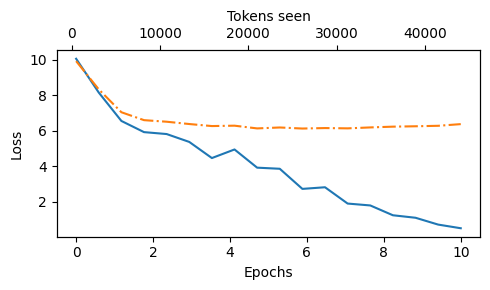

In [93]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, token_seen, train_losses, val_losses)

In [94]:
## DECODING STRATEGIES TO CONTROL RANDOMNESS

In [95]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=76

In [97]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model, 
    idx=text_to_token_ids("Every effort moves you", tokenizer), 
    max_new_tokens=25, 
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




In [98]:
### Temperature scaling

In [108]:
vocab = {
    "closer": 0, 
    "every": 1, 
    "effort": 2, 
    "forward": 3, 
    "inches": 4, 
    "moves": 5, 
    "pizza": 6,  
    "toward": 7, 
    "you": 8
}
inverse_vocab = {v: k for k, v in vocab.items()}

In [109]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [110]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item() 
print(inverse_vocab[next_token_id])

forward


In [111]:
torch.manual_seed(123) 
next_token_id = torch.multinomial(probas, num_samples=1).item() 
print(inverse_vocab[next_token_id])

forward


In [115]:
def print_sampled_tokens(probas): 
    torch.manual_seed(123) 
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids): 
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


In [116]:
def softmax_with_temperature(logits, temperature): 
    scaled_logits = logits / temperature 
    return torch.softmax(scaled_logits, dim=0)

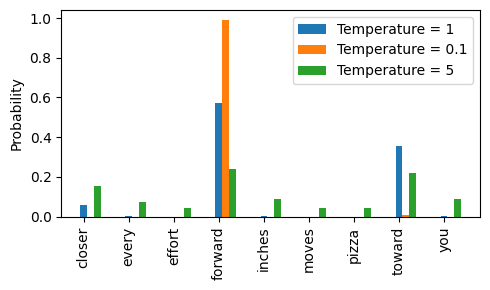

In [118]:
temperatures = [1, 0.1, 5] 
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15 
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures): 
    rects = ax.bar(x + i * bar_width, scaled_probas[i], 
                   bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x) 
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend() 
plt.tight_layout()
plt.show()

In [123]:
def print_sampled_tokens(logits, temperature): 
    torch.manual_seed(123) 
    scaled_probas = softmax_with_temperature(logits, temperature=temperature)
    sample = [torch.multinomial(scaled_probas, num_samples=1).item() for i in range(1000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids): 
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(next_token_logits, 1)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


In [124]:
print_sampled_tokens(next_token_logits, 0.1)

0 x closer
0 x every
0 x effort
985 x forward
0 x inches
0 x moves
0 x pizza
15 x toward


In [125]:
print_sampled_tokens(next_token_logits, 5)

165 x closer
75 x every
42 x effort
239 x forward
71 x inches
46 x moves
32 x pizza
227 x toward
103 x you


In [126]:
top_k = 3 
top_logits, top_pos = torch.topk(next_token_logits, top_k) 
print("Top logits:", top_logits)
print("Top positions:", top_pos) 

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [127]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1], 
    input=torch.tensor(float('-inf')), 
    other=next_token_logits 
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [128]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas) 

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [131]:
def generate(model, idx, max_new_tokens, context_size, top_k, temperature): 
    for _ in range(max_new_tokens): 
        idx_cond = idx[:, -context_size:]
        with torch.no_grad(): 
            logits = model(idx_cond) 
        logits = logits[:, -1, :]
        if top_k is not None: 
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1] 
            logits = torch.where(
                logits < min_val, 
                torch.tensor(float('-inf')).to(logits.device), 
                logits
            )
        if temperature > 0.0: 
            logits = logits /temperature 
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [134]:
torch.manual_seed(123)
token_ids = generate(
    model=model, 
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=15, 
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25, 
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you stand," she down." For Mrs. Gisburn! The women had


In [135]:
torch.save(model.state_dict(), "../models/model.pth")

In [136]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("../models/model.pth"))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=76

In [137]:
torch.save({
    "model_state_dict": model.state_dict(), 
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth")

In [139]:
checkpoint = torch.load("model_and_optimizer.pth")
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=76